In [1]:
# models/wavenet.py
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import losses, models
from tensorflow.keras.layers import (Add, Conv1D, Dense,
                                     GlobalAveragePooling1D, Input, Multiply)
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [2]:
import pandas as pd

In [3]:
def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):
    def build_residual_block(l_input):
        resid_input = l_input
        for dilation_rate in [2 ** i for i in range(stacked_layer)]:
            l_sigmoid_conv1d = Conv1D(
                num_filters, kernel_size, dilation_rate=dilation_rate,
                padding='same', activation='sigmoid')(l_input)
            l_tanh_conv1d = Conv1D(
                num_filters, kernel_size, dilation_rate=dilation_rate,
                padding='same', activation='relu')(l_input)
            l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            l_input = Conv1D(num_filters, 1, padding='same')(l_input)
            resid_input = Add()([resid_input, l_input])
        return resid_input

    return build_residual_block

In [4]:
def get_model(input_shape=(800, 12)):
    num_filters_ = 16
    kernel_size_ = 4
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=(input_shape))
    cat_input = Input(shape=(2,), name='cat_input')
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_ * 2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_ * 2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_ * 4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_ * 4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_ * 8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_ * 8, kernel_size_, stacked_layers_[3])(x)
    x = GlobalAveragePooling1D()(x)
    l_output = Dense(32, activation='relu')(x)
    concat_layer_out = tf.keras.layers.Concatenate()([l_output, cat_input])
    model_output = Dense(1, activation='sigmoid')(concat_layer_out)
    model = models.Model(inputs=[l_input, cat_input], outputs=[model_output])
    opt = Adam(lr=1e-3)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.BinaryCrossentropy(label_smoothing=0.001), metrics=['AUC'], optimizer=opt)
    return model

In [5]:
model = get_model()

In [6]:
import tqdm
import numpy as np

In [7]:
def read_data(data_contain_path):
    train = pd.read_csv(data_contain_path + '/train.csv')

    test = pd.read_csv(data_contain_path + '/test.csv')
    train["is_train"] = True
    test["is_train"] = False
    submit = pd.read_csv(data_contain_path + '/sample_submission.csv')

    return train, test, submit


def read_wave(paths):
    X = []
    for p in tqdm.tqdm(paths):
        X.append(np.load(p))
    return np.stack(X)

In [8]:
train, test, submit = read_data("../../data")
train_wave = read_wave("../../data/ecg/" + train["Id"] + ".npy")
train_y = train["target"]

train["sex"] = train["sex"].replace({"male": 0, "female": 1})

train_x = [
    train_wave, 
    train[["sex", "age"]]
]

100%|██████████| 2000/2000 [00:02<00:00, 942.24it/s]


In [9]:
model.load_weights('../../logs/wavenet/models/fold-0.ckpt')

In [10]:
_inp = [np.expand_dims(train_x[0][0], axis=0), np.expand_dims(train_x[1].iloc[0].values, axis=0)]

In [11]:
get_global_out = K.function(inputs=[model.input],
                                    outputs=[model.layers[-5].output])

In [12]:
import matplotlib.pyplot as plt

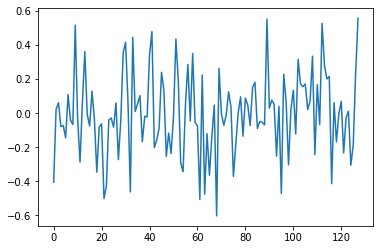

In [13]:
plt.plot(get_global_out(_inp)[0][0])

In [14]:
mi_index = train_y == 1

In [15]:
model.layers[-5]

In [16]:
import seaborn as sns
sns.set()

/Users/yuchi_ymgc/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/yuchi_ymgc/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


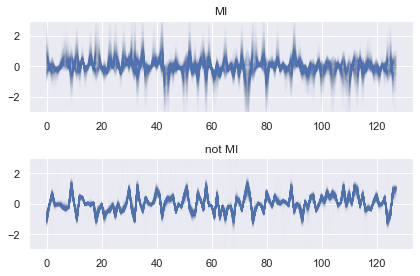

In [17]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.set_ylim([-3, 3])
ax1.set_title("MI")
ax2.set_ylim([-3, 3])
ax2.set_title("not MI")

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(get_global_out([train_x[0][mi_index][:500], train_x[1][mi_index][:500].values])[0].T, color="b", alpha=0.01)
ax2.plot(get_global_out([train_x[0][~mi_index][:500], train_x[1][~mi_index][:500].values])[0].T, color="b", alpha=0.01)    
fig.tight_layout()
plt.savefig("plot.png")